In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
# import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
# import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib
from matplotlib.ticker import AutoMinorLocator

import find_rip_particip_drift


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
basepath = r'Z:\Data\Kenji\km01.004_011'
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_stability_drift'

# these datasets don't have multiple mazes in the same session (as far as I know)
not_to_use = (
            (df['basepath'].str.contains("GirardeauG", case=False)) |
            (df['basepath'].str.contains("ORproject", case=False)) |
            (df['basepath'].str.contains("OMLproject", case=False)) |
            (df['basepath'].str.contains("GrosmarkAD", case=False))
            )
df = df.loc[~not_to_use]

find_rip_particip_drift.participation_run(df,save_path,parallel=True)

In [9]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
df = load_in_everything(save_path)

In [11]:
df.loc[df.pval <= 0.05,'sig'] = 'drifting'
df.loc[df.pval > 0.05,'sig'] = 'non_drifting'


In [12]:
df

,Unnamed: 0,pval,eta_sq,omega_sq,first_ep_mean_particip,basepath,sig
0,0,1.878504e-02,0.161862,0.115237,0.334754,Z:\Data\AYAold\AB3\AB3_38_41,drifting
1,1,9.314305e-01,0.007793,-0.044571,0.162826,Z:\Data\AYAold\AB3\AB3_38_41,non_drifting
2,2,2.109496e-05,0.350249,0.311823,0.408427,Z:\Data\AYAold\AB3\AB3_38_41,drifting
3,3,1.907174e-03,0.231815,0.188083,0.339484,Z:\Data\AYAold\AB3\AB3_38_41,drifting
4,4,2.871876e-01,0.064585,0.014235,0.178691,Z:\Data\AYAold\AB3\AB3_38_41,non_drifting
...,...,...,...,...,...,...,...
788,66,5.313206e-09,0.312674,0.292104,0.198495,Z:\Data\Kenji\i01_maze15_MS.001_004,drifting
789,67,2.680901e-03,0.120372,0.095618,0.057362,Z:\Data\Kenji\i01_maze15_MS.001_004,drifting
790,68,4.241382e-01,0.024987,-0.001590,0.085769,Z:\Data\Kenji\i01_maze15_MS.001_004,non_drifting
791,69,1.361398e-09,0.329790,0.309625,0.015408,Z:\Data\Kenji\i01_maze15_MS.001_004,drifting


<AxesSubplot:xlabel='first_ep_mean_particip', ylabel='Density'>

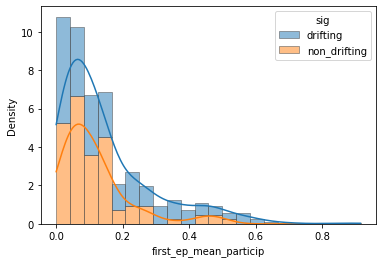

In [23]:
# sns.scatterplot(x="eta_sq", y="first_ep_mean_particip",
#                 hue="sig",
#                 data=df)

sns.histplot(
    df,
    x="first_ep_mean_particip", hue="sig",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,kde=True,stat="density", common_norm=False
)

# testing below

In [4]:
basepath = r'Z:\Data\Kenji\km01.004_011'

cell_metrics,data,ripples,fs_dat = find_rip_particip_drift.load_basic_data(basepath)

restrict_idx = (
                    (cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False) 
                    )

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

# if cell_metrics.shape[0] == 0:
#     return

# behavioral epochs
epoch_df = loading.load_epoch(basepath)
# some epochs will have repeating back to back sessions that are actually the same session
epoch_df = functions.compress_repeated_epochs(epoch_df)

# make sure there are enough epochs
# epoch_types = epoch_df.environment.unique()
# if ~(sum(epoch_types != 'sleep') > 1):
#     return

behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                epoch_df.stopTime]).T])

# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])

try:
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
except:
    # if only 1 cell, try this
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx][0], fs=fs_dat)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [295]:
bst = st_unit.bin(ds=.03).smooth(sigma=.04)
bst

<BinnedSpikeTrainArray at 0x1d63e5d4d90: 30 series in 211,792 bins of width 30.0 milliseconds> for a total of 1:45:53:760 hours

In [296]:
df_catagories = pd.DataFrame()
df_catagories['bin_centers'] = bst.bin_centers
df_catagories['ripple'] = np.zeros_like(bst.bin_centers)

for rip in ripples.itertuples():
    idx = (bst.bin_centers >= rip.start - .01) & (bst.bin_centers <= rip.stop + .01)
    df_catagories.loc[idx,'ripple'] = 1

for ep in epoch_df.itertuples():
    idx = (bst.bin_centers >= ep.startTime) & (bst.bin_centers <= ep.stopTime)
    df_catagories.loc[idx,'epoch'] = ep.name

df_catagories['fr'] = bst.data[2]


<AxesSubplot:xlabel='bin_centers', ylabel='fr'>

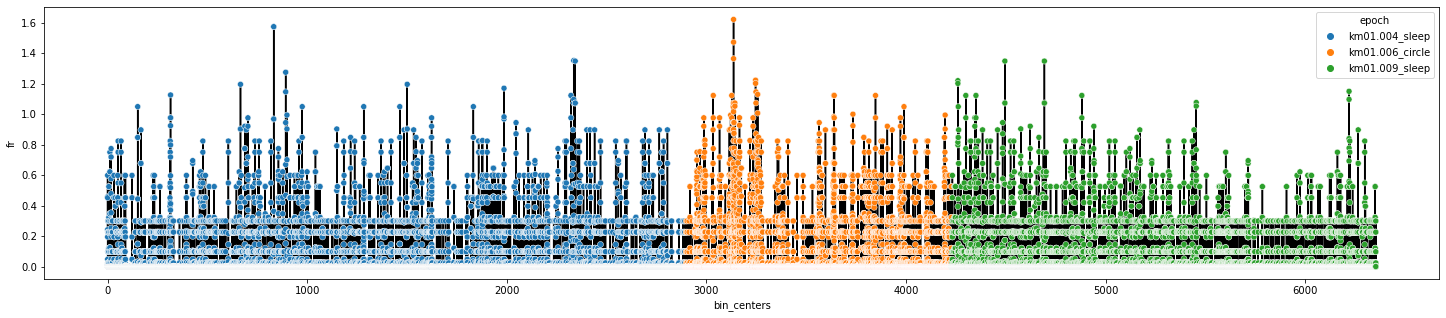

In [297]:
# plt.plot(df_catagories.epoch,df_catagories.fr,'.k')
# plt.plot(df_catagories.ripple,bst.data[6],'.k')
plt.figure(figsize=(25,5))

plt.plot(df_catagories.bin_centers,df_catagories.fr,zorder=-1000,color='k')
sns.scatterplot(x="bin_centers", y="fr",
                hue="epoch",data=df_catagories)

In [244]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

X, y = make_regression(random_state=1, n_samples=300, noise=100)

print(cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2'))
print(cross_val_score(LinearRegression(), X, y, scoring='r2'))

[0.363997   0.28253087 0.3445757  0.50863318 0.6248952 ]
[0.363997   0.28253087 0.3445757  0.50863318 0.6248952 ]


In [313]:
# import random
    # idx = np.sort(random.sample(list(np.arange(n_rows)),n_samples))

n_rows = df_catagories.shape[0]
n_samples = int(n_rows*.30)
for i in range(10):
    idx = np.sort(np.random.choice(n_rows, n_samples, replace=False))

    best_model = test_models(df_catagories.loc[idx])        
    print(best_model) 

fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch


In [353]:
df_catagories_dummy = pd.get_dummies(df_catagories, columns=["epoch"])
epoch_names = ['epoch_'+df_catagories.epoch.unique()][0]
X = df_catagories_dummy[list(['ripple'])+list(epoch_names)].values

interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(X) 
X_inter


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [369]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression

cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 2021)
reg = LinearRegression()
scores = cross_val_score(reg, X[:,1:], df_catagories.fr.values, cv = cv,scoring='explained_variance') # 5-fold repeated cross validation
print('Mean Accuracy: ',scores.mean())

scores = cross_val_score(reg, X[:,0].reshape(-1, 1), df_catagories.fr.values, cv = cv,scoring='explained_variance') # 5-fold repeated cross validation
print('Mean Accuracy: ',scores.mean())

scores = cross_val_score(reg, X_inter, df_catagories.fr.values, cv = cv,scoring='explained_variance') # 5-fold repeated cross validation
print('Mean Accuracy: ',scores.mean())

Mean Accuracy:  0.03107462773512419
Mean Accuracy:  0.02032781789786507
Mean Accuracy:  0.054515174709068644


In [359]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [312]:
def test_models(df_catagories):
        models = ['fr ~ ripple * epoch',
                'fr ~ ripple',
                'fr ~ epoch']
        llf = []  
        bic = []
        aic = []      
        for model in models:
                m01 = ols(model, data=df_catagories).fit()
                aic.append(m01.aic)
                bic.append(m01.bic)
                llf.append(m01.llf)

        if np.argmin(aic) == np.argmin(bic) == np.argmax(llf):
                best_model = models[np.argmin(aic)]
        else:
                best_model = 'unknown'
        return best_model

for i in range(bst.data.shape[0]):
        df_catagories['fr'] = bst.data[i]

        best_model = test_models(df_catagories)       
        print(best_model) 

fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch
fr ~ ripple * epoch


fr ~ ripple * epoch
fr ~ ripple
fr ~ epoch


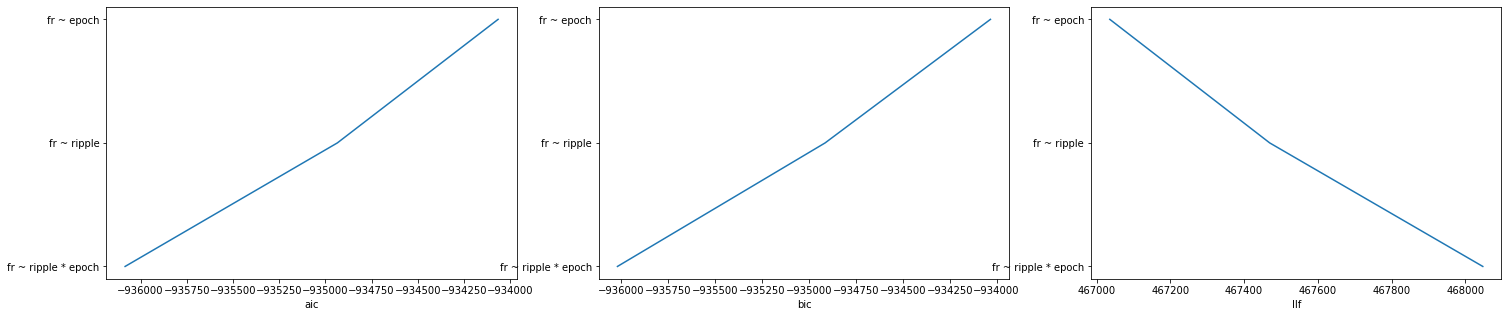

In [235]:
fig,ax = plt.subplots(1,3,figsize=(25,5))
ax[0].plot(aic,models)
ax[0].set_xlabel('aic')
ax[1].plot(bic,models)
ax[1].set_xlabel('bic')
ax[2].plot(llf,models)
ax[2].set_xlabel('llf')
# print(models)

# models[np.argmin(aic)]

print(*np.array(models)[np.argsort(aic)],sep='\n')


In [236]:
m01 = ols('fr ~ ripple * epoch', data=df_catagories).fit()
print(m01.summary())
anovaResults = anova_lm(m01, typ=2)
anovaResults

                            OLS Regression Results                            
Dep. Variable:                     fr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     566.1
Date:                Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:40:49   Log-Likelihood:             4.6805e+05
No. Observations:              317688   AIC:                        -9.361e+05
Df Residuals:                  317682   BIC:                        -9.360e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

,sum_sq,df,F,PR(>F)
epoch,2.986341,2.0,485.581515,2.730947e-211
ripple,5.667823,1.0,1843.185036,0.000000e+00
ripple:epoch,0.576488,2.0,93.737483,2.006022e-41
Residual,976.877109,317682.0,NaN,NaN


In [237]:
m01 = ols('fr ~ ripple', data=df_catagories).fit()
m02 = ols('fr ~ ripple * epoch', data=df_catagories).fit()
anovaResults = anova_lm(m01, m02)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,317686.0,980.439939,0.0,NaN,NaN,NaN
1,317682.0,976.877109,4.0,3.56283,289.659499,4.214401e-249


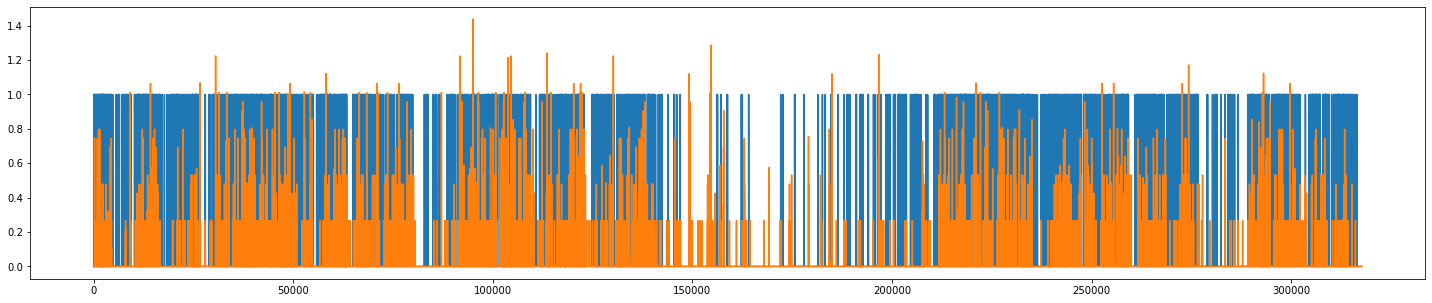

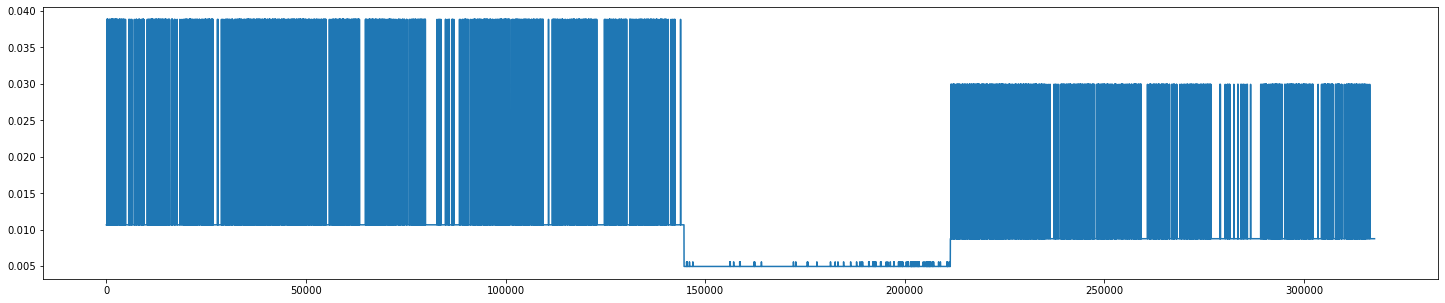

In [195]:
plt.figure(figsize=(25,5))
plt.plot(df_catagories.ripple)
plt.plot(df_catagories.fr)
plt.figure(figsize=(25,5))

plt.plot(m01.predict(df_catagories[['ripple','epoch']]))


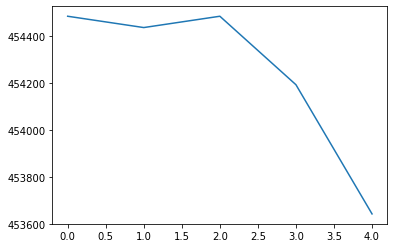

In [160]:
plt.plot(llf)

In [143]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.transform(df_catagories.epoch.values.reshape(-1, 1)).toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

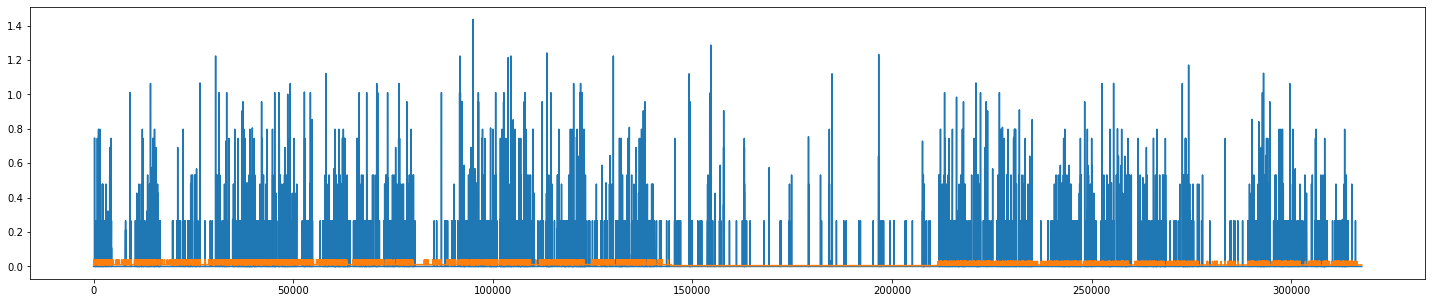

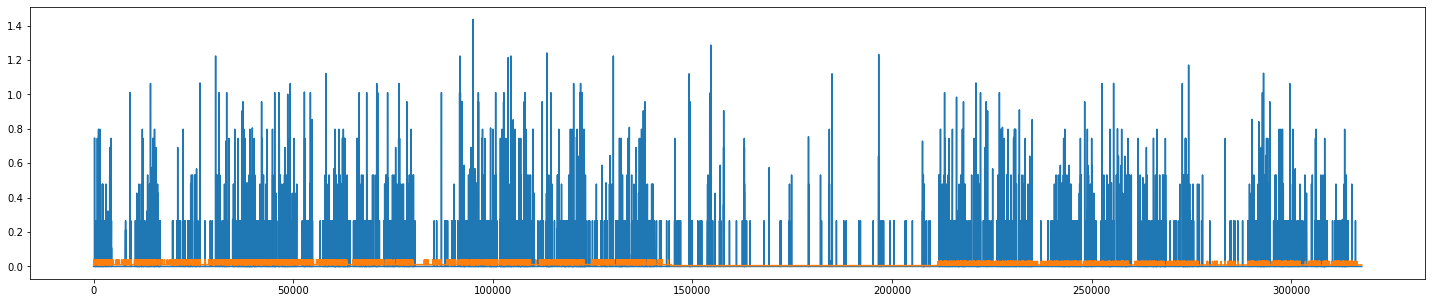

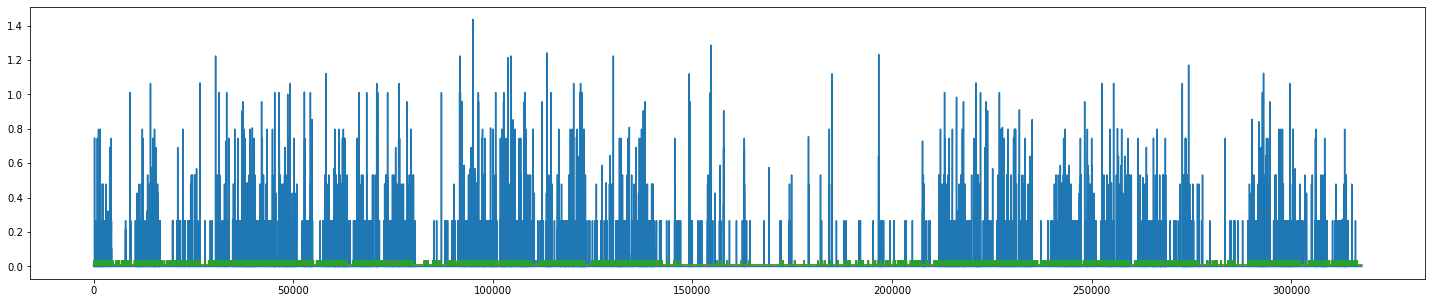

In [135]:
plt.figure(figsize=(25,5))
plt.plot(df_catagories['fr'])
m01 = ols('fr ~ ripple + epoch + ripple * epoch', data=df_catagories).fit()
plt.plot(m01.fittedvalues)

plt.figure(figsize=(25,5))
plt.plot(df_catagories['fr'])
m01 = ols('fr ~ ripple + epoch + ripple * epoch', data=df_catagories).fit_regularized()
plt.plot(m01.fittedvalues)

plt.figure(figsize=(25,5))
plt.plot(df_catagories['fr'])
m01 = ols('fr ~ ripple', data=df_catagories).fit()
plt.plot(m01.fittedvalues)
plt.plot(m01.predict(df_catagories.ripple))



In [144]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# test = SelectKBest(score_func=chi2, k=1)
# fit = test.fit(df_catagories[['ripple']].values, df_catagories['fr'].values)


In [132]:
# plt.figure(figsize=(25,5))
# plt.plot(df_catagories.bin_centers,df_catagories.ripple)
# plt.xlim(0,100)
# df_catagories
# plt.plot(df_catagories.ripple,bst.data[6],'.k')
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

df_catagories['fr'] = bst.data[6]

m01 = ols('fr ~ ripple + epoch + ripple * epoch', data=df_catagories).fit()
print(m01.summary())
anovaResults = anova_lm(m01, typ=2)
anovaResults

                            OLS Regression Results                            
Dep. Variable:                     fr   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     460.3
Date:                Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:18:38   Log-Likelihood:             4.5449e+05
No. Observations:              317688   AIC:                        -9.090e+05
Df Residuals:                  317682   BIC:                        -9.089e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

,sum_sq,df,F,PR(>F)
epoch,1.634904,2.0,244.081020,1.197625e-106
ripple,5.339680,1.0,1594.361815,0.000000e+00
ripple:epoch,0.323341,2.0,48.272827,1.092856e-21
Residual,1063.949396,317682.0,NaN,NaN


C:\Users\Cornell\AppData\Local\Temp/ipykernel_31520/476379167.py:9: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:238: UserWarning: fs was estimated to be 0.008333333333333333 Hz


<AnalogSignalArray at 0x1d606e79e80: 30 signals (2 segments)> for a total of 1:42:00 hours

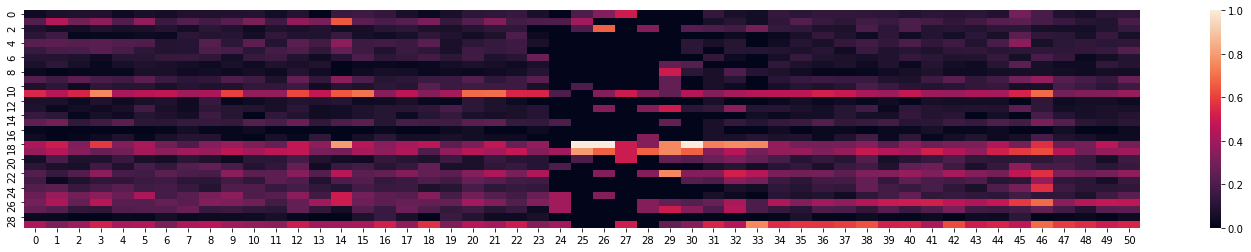

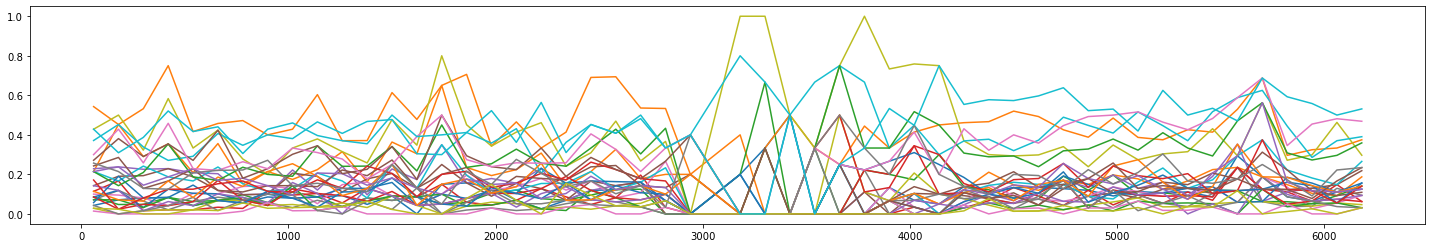

In [ ]:
bin_width = 120
bins = np.arange(behavioral_epochs.start,behavioral_epochs.stop,bin_width)
bin_centers = bins[0:-1] + bin_width/2
particip = []
n_ripples = []
for i in range(bins.shape[0]-1):
    idx = (unit_mat.abscissa_vals >= bins[i]) & (unit_mat.abscissa_vals <= bins[i+1])
    n_ripples.append(sum(idx))
    particip.append(np.sum(unit_mat.data[:,idx] == 1,axis=1)  / unit_mat.data[:,idx].shape[1])

particip = np.vstack(particip)
particip[np.isnan(particip)] = 0

# make sure each bin has at least 1 ripples
keep_idx = np.array(n_ripples)>0
particip = particip[keep_idx,:]
bin_centers = bin_centers[keep_idx]

unit_mat_binned = nel.AnalogSignalArray(data=particip.T,timestamps=bin_centers)

plt.figure(figsize=(25,4))

sns.heatmap(particip.T)    
plt.figure(figsize=(25,4))

plt.plot(unit_mat_binned.abscissa_vals,  unit_mat_binned.data.T)


unit_mat_binned

C:\Users\Cornell\AppData\Local\Temp/ipykernel_31520/476379167.py:9: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:238: UserWarning: fs was estimated to be 0.008333333333333333 Hz


<AnalogSignalArray at 0x1d606e79e80: 30 signals (2 segments)> for a total of 1:42:00 hours

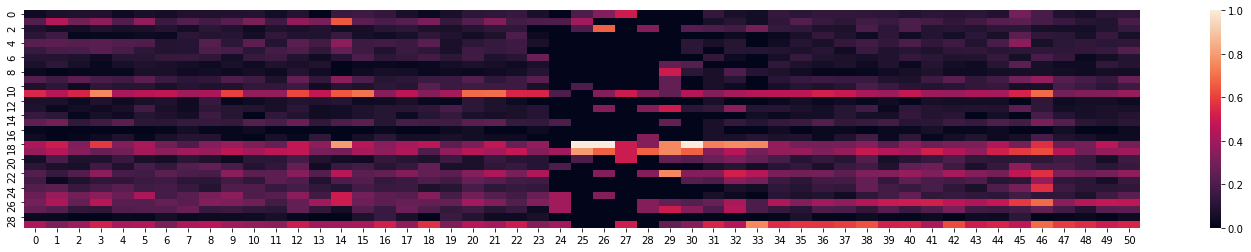

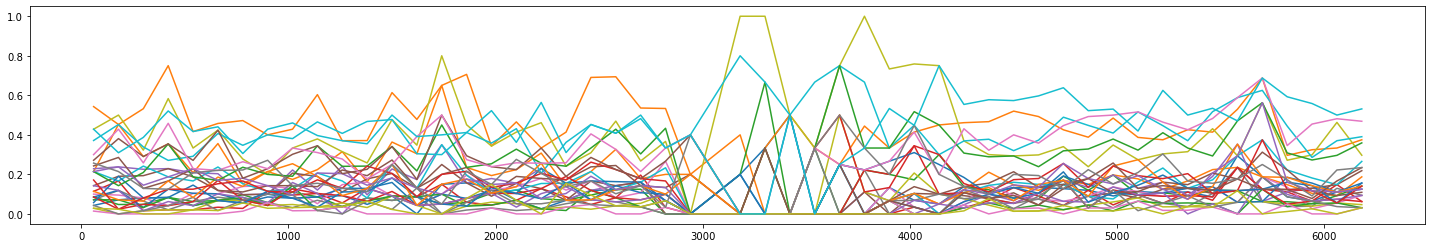

In [165]:
bin_width = 120
bins = np.arange(behavioral_epochs.start,behavioral_epochs.stop,bin_width)
bin_centers = bins[0:-1] + bin_width/2
particip = []
n_ripples = []
for i in range(bins.shape[0]-1):
    idx = (unit_mat.abscissa_vals >= bins[i]) & (unit_mat.abscissa_vals <= bins[i+1])
    n_ripples.append(sum(idx))
    particip.append(np.sum(unit_mat.data[:,idx] == 1,axis=1)  / unit_mat.data[:,idx].shape[1])

particip = np.vstack(particip)
particip[np.isnan(particip)] = 0

# make sure each bin has at least 1 ripples
keep_idx = np.array(n_ripples)>0
particip = particip[keep_idx,:]
bin_centers = bin_centers[keep_idx]

unit_mat_binned = nel.AnalogSignalArray(data=particip.T,timestamps=bin_centers)

plt.figure(figsize=(25,4))

sns.heatmap(particip.T)    
plt.figure(figsize=(25,4))

plt.plot(unit_mat_binned.abscissa_vals,  unit_mat_binned.data.T)


unit_mat_binned

In [167]:
# def smooth_unit_mat_moving_mean(unit_mat,window=60, min_periods=3):
#     """
#     smooth with irregular time in mind to minimize bias of far away events
#     Input:  unit_mat: AnalogSignalArray object
#             window: smoothing window in seconds
#             min_periods: minimum data points for window, output values will drop to 0 if not met

#     Output: unit_mat_sm: AnalogSignalArray object after smooth
    
#     """
#     # make copy 
#     unit_mat_sm = unit_mat.copy()
#     # pull out and format ts
#     ts = [pd.Timestamp(val,unit='s') for val in unit_mat.abscissa_vals]
#     # make data frame with ts as index
#     df = pd.DataFrame(unit_mat.data.T,index=ts,columns=np.arange(unit_mat.data.shape[0]))
#     # smooth with moving mean
#     smoothed = df.rolling(str(window)+'s', min_periods=min_periods).mean().fillna(0)
#     # add to object
#     unit_mat_sm.data = smoothed.values.T

#     return unit_mat_sm

# unit_mat_sm = smooth_unit_mat_moving_mean(unit_mat)

# plt.figure(figsize=(25,4))
# sns.heatmap(unit_mat.data)
# plt.show()

# plt.figure(figsize=(25,4))
# sns.heatmap(unit_mat_sm.data)

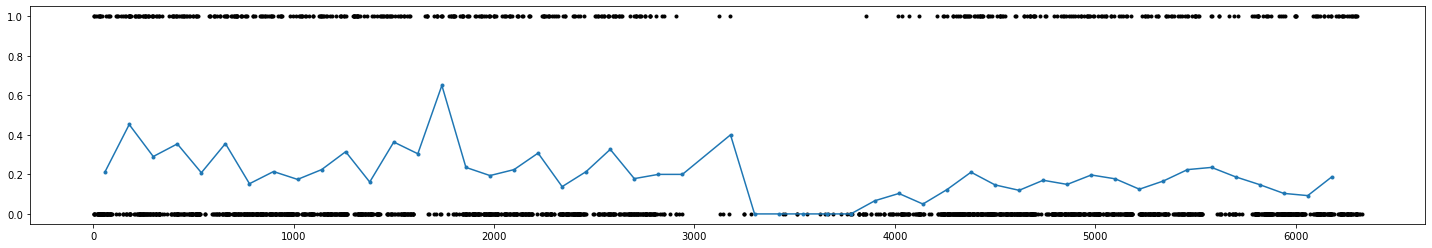

In [168]:
plt.figure(figsize=(25,4))
plt.plot(unit_mat.abscissa_vals, unit_mat.data[1],'.k',label='raw')
plt.plot(unit_mat_binned.abscissa_vals,unit_mat_binned.data[1],label='rolling',marker='.')

In [175]:
def anova_table(aov):
    """
    The function was created specifically for the one-way ANOVA table results returned for Type II sum of squares
    """
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def find_drift(unit_mat_binned,epoch_df):

    pval = []
    eta_sq = []
    omega_sq = []
    first_ep_mean_particip = []
    for i in range(unit_mat_binned.data.shape[0]):
        y = unit_mat_binned.data[i]
        df = pd.DataFrame()
        df['ts'] = unit_mat_binned.abscissa_vals
        df['constant'] = np.ones_like(unit_mat_binned.abscissa_vals)[0]
        df['y'] = y

        for ep in epoch_df.itertuples():
            idx = (df.ts >= ep.startTime) & (df.ts <= ep.stopTime)
            df.loc[idx,'ep'] = ep.name

        m01 = ols('y ~ ep', data=df).fit()
        anovaResults = anova_lm(m01, typ=2, robust="hc3")

        anovaResults = anova_table(anovaResults)

        first_ep_mean_particip.append(df[df.ep == df.ep.unique()[0]].y.mean())

        pval.append(anovaResults['PR(>F)']['ep'])
        eta_sq.append(anovaResults['eta_sq']['ep'])
        omega_sq.append(anovaResults['omega_sq']['ep'])

    df = pd.DataFrame()
    df['pval'] = pval
    df['eta_sq'] = eta_sq
    df['omega_sq'] = omega_sq
    df['first_ep_mean_particip'] = first_ep_mean_particip

    return df

df = find_drift(unit_mat_binned,epoch_df)    

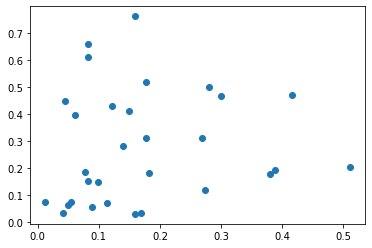

In [178]:
plt.scatter(df.first_ep_mean_particip,df.eta_sq)

<AxesSubplot:>

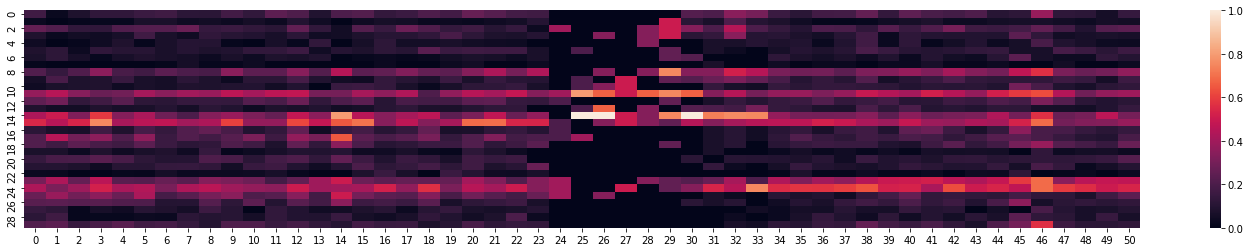

In [179]:
plt.figure(figsize=(25,4))

sns.heatmap(unit_mat_binned.data[np.argsort(df.eta_sq)])

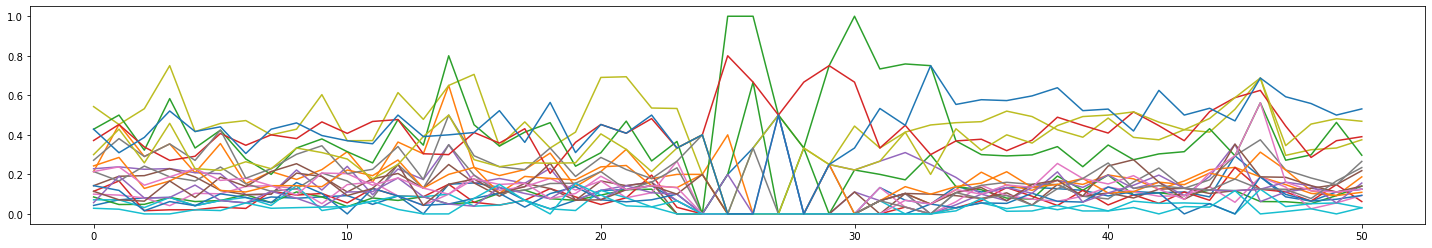

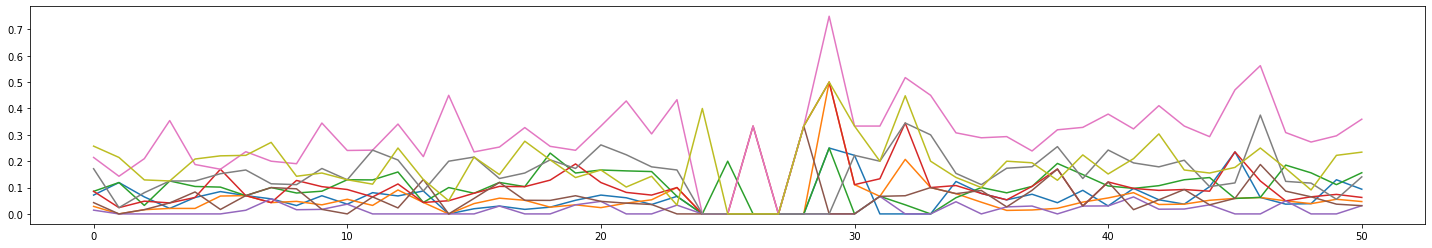

In [176]:

plt.figure(figsize=(25,4))
plt.plot(unit_mat_binned.data[np.array(df.pval) < 0.05].T)
plt.show()
plt.figure(figsize=(25,4))

plt.plot(unit_mat_binned.data[np.array(df.pval) > 0.05].T)
plt.show()

<AxesSubplot:xlabel='ts', ylabel='y'>

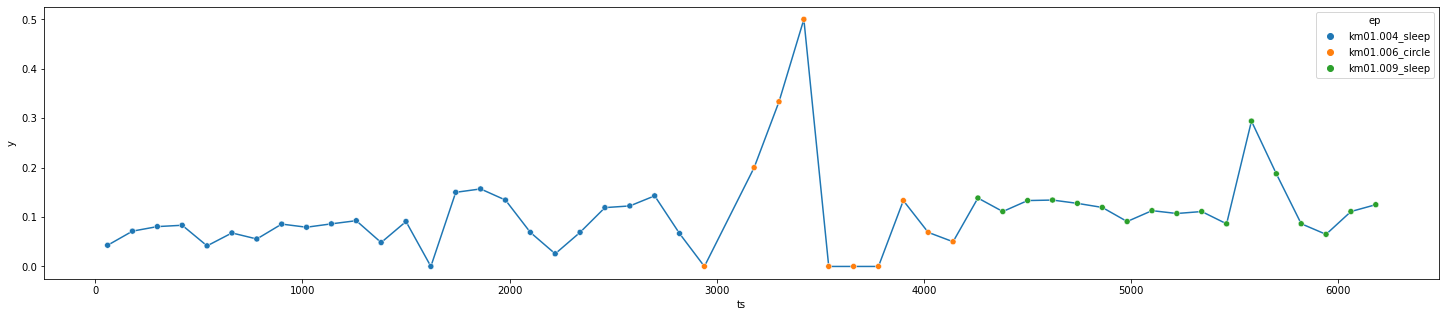

In [172]:
y = unit_mat_binned.data[0]

# epochs = []
# for i in range(behavioral_epochs.n_intervals):
#     unit_mat_sm[behavioral_epochs[i]]
#     epochs.append(np.zeros([1,unit_mat_sm[behavioral_epochs[i]].data.shape[1]])+i)
# epochs = np.hstack(epochs).T

df = pd.DataFrame()
df['ts'] = unit_mat_binned.abscissa_vals
df['constant'] = np.ones_like(unit_mat_binned.abscissa_vals)[0]

# df['ep'] = epochs
df['y'] = y

for ep in epoch_df.itertuples():
    idx = (df.ts >= ep.startTime) & (df.ts <= ep.stopTime)
    df.loc[idx,'ep'] = ep.name
df

plt.figure(figsize=(25,5))
plt.plot(df.ts,df.y,zorder=-1000)
sns.scatterplot(x="ts", y="y",
                hue="ep",
                data=df)

In [44]:
df['y_trans'] = np.log(df.y + 2)

           sum_sq     df          F        PR(>F)
ep        1.85890    4.0  45.782782  1.733108e-24
Residual  1.41094  139.0        NaN           NaN


<AxesSubplot:xlabel='ep', ylabel='y'>

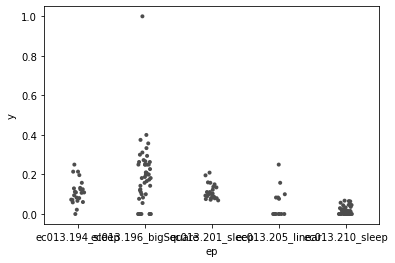

In [108]:
# import statsmodels.api as sm
# X = sm.add_constant(X)
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

m01 = ols('y ~ ep', data=df).fit()
# print(m01.summary())
anovaResults = anova_lm(m01, typ=2, robust="hc3")
print(anovaResults)

# sns.boxplot(x="ep", y="y",
#             data=df)
plt.figure()
ax = plt.gca()
sns.stripplot(x="ep", y="y", data=df,
              size=4, color=".3", linewidth=0,ax=ax)
# plt.yscale('log')

# sns.catplot(x="ep", y="y", hue="ep",
#                 capsize=.2, palette="YlGnBu_d",
#                 kind="point", data=df,ax=ax)

In [63]:
df

,ts,constant,y,ep
0,2.1616,1.0,0.000000,ec013.194_sleep
1,2.2600,1.0,0.000000,ec013.194_sleep
2,3.1728,1.0,0.333333,ec013.194_sleep
3,3.2712,1.0,0.250000,ec013.194_sleep
4,6.3944,1.0,0.400000,ec013.194_sleep
...,...,...,...,...
5584,17287.6072,1.0,0.314286,ec013.210_sleep
5585,17289.5720,1.0,0.314286,ec013.210_sleep
5586,17290.7336,1.0,0.285714,ec013.210_sleep
5587,17321.1496,1.0,0.375000,ec013.210_sleep


In [9]:
# df = pd.concat([df,pd.get_dummies(df.ep,drop_first=True)],axis=1)

In [55]:
# df['ep1'] = df[1.0]
# df['ep2'] = df[2.0]
# df.drop([1.0, 2.0], axis=1)

In [11]:
# df.to_csv(r'C:\Users\Cornell\Downloads\df.csv')

In [66]:
# from sklearn.linear_model import LinearRegression

# X = df[['constant','ts','ep']].values
# reg = LinearRegression().fit(X, y)

# X = df[['constant','ts']].values
# reg2 = LinearRegression().fit(X, y)

In [14]:
# plt.figure(figsize=(25,5))
# plt.plot(df['ts'],y)
# plt.plot(df['ts'],reg.predict(df[['constant','ts','ep1','ep2']].values))
# plt.plot(df['ts'],reg2.predict(df[['constant','ts']].values))


In [13]:
# df = df[df.y > 0]
# df['y_log'] = np.log(df.y)

In [12]:
import pingouin as pg
res = pg.rm_anova(dv='y',within='ep', subject='constant',data=df)
res

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\pingouin\parametric.py:553: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\pandas\core\frame.py:8276: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply


LinAlgError: Eigenvalues did not converge

In [15]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


m01 = ols('y ~ constant + ts', data=df).fit()
m02 = ols('y ~ constant + ts + ep1 + ep2', data=df).fit()
anovaResults = anova_lm(m01, m02)

print(anovaResults)


   df_resid        ssr  df_diff  ss_diff          F        Pr(>F)
0    2353.0  11.125391      0.0      NaN        NaN           NaN
1    2351.0  10.881762      2.0  0.24363  26.318062  4.969153e-12


In [16]:
print(m02.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     98.57
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           4.27e-60
Time:                        16:54:21   Log-Likelihood:                 2990.1
No. Observations:                2355   AIC:                            -5972.
Df Residuals:                    2351   BIC:                            -5949.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0319      0.002     19.918      0.0